<h1>Dataset</h1>

In [2]:
import os
import numpy as np
import pandas as pd
import polars as pl
import re

# Dimensionality Reduction
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE
import umap
import umap.plot

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.N

<h3>Load Data</h3>

In [3]:
demo_stats_df = pl.read_csv("Coursework Data/DemoStats.csv", null_values=None)
household_spend_df = pl.read_csv("Coursework Data/HouseholdSpend.csv", null_values=None)

<h3>Null Values</h3>

In [4]:
# Define a function to convert NA to None
def convert_na_to_nulls(df):
    return df.with_columns([
        pl.col(col).replace("NA", None).alias(col)
        if df.schema[col] == pl.Utf8 else pl.col(col)
        for col in df.columns
    ])

# Convert NA to None on both dataframes
demo_stats_df = convert_na_to_nulls(demo_stats_df)
household_spend_df = convert_na_to_nulls(household_spend_df)

# Get total nulls for each column
def count_na_strings(df):
    total_rows = df.height
    return {
        col: {
            "null_count": df[col].null_count(),
            "null_percent": round((df[col].null_count() / total_rows) * 100, 2)
        }
        for col in df.columns
        if df[col].null_count() > 0
    }

demo_stats_null_cols = count_na_strings(demo_stats_df)
household_spend_null_cols = count_na_strings(household_spend_df)
# Initial Null Count for each csv file
print("Demo Stats Null Count:", demo_stats_null_cols)
print("Household Stats Null Count:", household_spend_null_cols)

Demo Stats Null Count: {'ECYPTAMED': {'null_count': 87459, 'null_percent': 10.06}, 'ECYPMAMED': {'null_count': 96444, 'null_percent': 11.1}, 'ECYPFAMED': {'null_count': 131837, 'null_percent': 15.17}, 'ECYHTAMED': {'null_count': 92709, 'null_percent': 10.67}, 'ECYHMAMED': {'null_count': 101698, 'null_percent': 11.7}, 'ECYHFAMED': {'null_count': 137900, 'null_percent': 15.87}, 'ECYMTNMED': {'null_count': 92709, 'null_percent': 10.67}}
Household Stats Null Count: {}


<p>Here we can see that demo stats has numerous columns with null values. Since the percentage of null values is around 10% for each, we 
will have to drop these columns, as it is greater than the 1% threshold.</p>
<p>We can also see that household stats has no null values, so we don't need to modify this dataset as of right now.</p>

In [5]:
# Drop selected null value columns
demo_stats_df = demo_stats_df.drop(null_cols for null_cols in demo_stats_null_cols)

<h3>Negative Values</h3>

In [6]:
# Get total negative values for each column
def count_negative_values(df):
    return {
        col: {
            "negative_count": df[col].filter(df[col] < 0).len(),
            "negative_percent": round((df[col].filter(df[col] < 0).len() / df.height) * 100, 2)
        }
        for col in df.columns
        if df.schema[col] in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                              pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                              pl.Float32, pl.Float64]
        and df[col].filter(df[col] < 0).len() > 0
    }

# Get total negative values for each dataframe
demo_stats_negatives = count_negative_values(demo_stats_df)
household_spend_negatives = count_negative_values(household_spend_df)

# Initial Negative Count for each csv file
print("Demo Stats Negative Values:", demo_stats_negatives)
print("Household Spend Negative Values:", household_spend_negatives)

Demo Stats Negative Values: {}
Household Spend Negative Values: {'HSTT001': {'negative_count': 28, 'negative_percent': 0.0}, 'HSTE001ZBS': {'negative_count': 163557, 'negative_percent': 18.82}, 'HSWH040S': {'negative_count': 255858, 'negative_percent': 29.44}, 'HSWH041S': {'negative_count': 15436, 'negative_percent': 1.78}, 'HSWH042S': {'negative_count': 19205, 'negative_percent': 2.21}}


<p>We can see that demo stats has no negative values, so we don't need to modify this dataset as of right now.</p>
<p>For household spending, we can see that there are negative values in the dataset:<p>
<ul>
<li>HSTT001 - Total expenditure,Household Expenditures (Category Summary),Dollars</li>
<li>HSTE001ZBS - Total non-current consumption,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH040S,Net purchase price of owned residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH041S - Net purchase price of owned secondary residences,Household Expenditures (Category Summary),Dollars</li>
<li>HSWH042S - Net purchase price of other owned properties,Household Expenditures (Category Summary),Dollars</li>
</ul>
<p>We can easily tell that the first two varaibles cannot be negative, since they desribe expenditures, and because they capture sums of outflows. The next 3 are tricky, because these variables reflect the net purchase price of owned residences, secondary residences, and other properties, they can indeed be negative if the proceeds from selling those properties exceed any purchase or improvement costs, thereby indicating a net inflow rather than an outflow.</p>
<p>Therefore, we will drop the first two variables, and keep the last three.</p>

In [7]:
# Drop selected negative value columns
household_spend_df = household_spend_df.drop(["HSTT001", "HSTE001ZBS"])

<h3>Outliers</h3>

In [25]:
# Function to find outliers in a dataframe
def find_outlier_columns(df):
    outlier_columns = {}

    for col in df.columns:
        dtype = df.schema[col]
        series = df[col]

        if dtype == pl.Int64 or dtype == pl.UInt64:
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = df.filter((series < lower) | (series > upper))

            if outliers.height > 0:
                outlier_columns[col] = f"{outliers.height} outliers (IQR)"

        elif dtype == pl.Float64:
            mean = series.mean()
            std = series.std()
            if std == 0:
                continue
            z = series - mean
            z_scores = z / std
            outliers = df.filter(z_scores.abs() > 3)

            if outliers.height > 0:
                outlier_columns[col] = f"{outliers.height} outliers (Z-score)"

        elif dtype == pl.Utf8:
            mode = series.mode()
            mode_val = mode[0] if mode.len() > 0 else None
            non_mode = df.filter(series != mode_val)

            if non_mode.height > 0:
                outlier_columns[col] = f"{non_mode.height} values not equal to mode '{mode_val}'"

    return outlier_columns



# Find outliers in both dataframes
demo_stats_outliers = find_outlier_columns(demo_stats_df)
household_spend_outliers = find_outlier_columns(household_spend_df)

# Initial Outliers for each csv file
print("Demo Stats Outliers:", demo_stats_outliers)
print("Household Spend Outliers:", household_spend_outliers)

Demo Stats Outliers: {'CODE': "868969 values not equal to mode 'H4H1K4'", 'ECYBASPOP': '77816 outliers (IQR)', 'ECYBASHHD': '66196 outliers (IQR)', 'ECYBASHPOP': '77625 outliers (IQR)', 'ECYBAS12P': '76250 outliers (IQR)', 'ECYBAS15P': '74664 outliers (IQR)', 'ECYBAS18P': '72835 outliers (IQR)', 'ECYBAS19P': '70543 outliers (IQR)', 'ECYBAS12HP': '74737 outliers (IQR)', 'ECYBAS15HP': '76156 outliers (IQR)', 'ECYBAS18HP': '71312 outliers (IQR)', 'ECYBAS19HP': '74291 outliers (IQR)', 'ECYBASTNGH': '77367 outliers (IQR)', 'ECYBASADUH': '79448 outliers (IQR)', 'ECYBASCF': '75923 outliers (IQR)', 'ECYBASCFH': '78586 outliers (IQR)', 'ECYBASKID': '91390 outliers (IQR)', 'ECYBASLF': '82696 outliers (IQR)', 'ECYPTAPOP': '77816 outliers (IQR)', 'ECYPTA_0_4': '72849 outliers (IQR)', 'ECYPTA_5_9': '83501 outliers (IQR)', 'ECYPTA1014': '88848 outliers (IQR)', 'ECYPTA1519': '72153 outliers (IQR)', 'ECYPTA2024': '76334 outliers (IQR)', 'ECYPTA2529': '76899 outliers (IQR)', 'ECYPTA3034': '80286 outlie

<p>To handle outliers...</p>

In [26]:
# OUTLIER CODE HERE

<h3>Merging Datasets</h3>

In [8]:
merged_df = demo_stats_df.join(
    household_spend_df,
    on=["CODE", "GEO"],
    how="inner"
)

merged_df.describe()

statistic,CODE,GEO,ECYASQKM,ECYALSQKM,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""868970""","""868970""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,0.0,0.0,46.684199,18.432629,45.881762,41.254934,39.613594,37.819792,37.323999,40.336732,38.832472,37.263988,36.746572,3.072744,24.49923,12.76093,12.051364,12.740845,24.633679,46.684199,2.181318,2.390635,2.498651,2.672259,3.213171,3.308621,3.406466,3.258362,3.117668,2.858167,2.776588,2.859335,3.10898,2.80384,…,236398.761036,118477.006209,114562.677761,14888.288571,8607.895903,91066.493288,188.957063,83.539013,105.41805,3725.371385,3469.552047,2092.59778,1376.954267,255.819338,1504.664209,116417.090618,3287.664753,10103.061471,12676.188385,18214.142317,100.530695,63415.559732,2639.560863,4612.181943,1368.200459,379.01064,989.189819,34736.610626,5995.306708,2258.469958,915.416319,23038.220756,71.1409,1322.434304,831.592595,490.84171,1135.621681
"""std""",null,null,0.0,0.0,174.837877,69.379951,171.817976,152.539099,145.876662,139.320601,137.611402,149.038058,143.038376,137.181937,135.319262,12.468123,87.647782,50.126862,47.828225,49.02113,89.352097,174.837877,9.518254,10.400337,10.705186,10.30089,10.888878,10.894537,11.699239,11.371185,11.099312,10.485757,10.544898,11.657788,13.69638,12.729886,…,990960.632583,507452.95803,494184.487741,58848.760548,45895.371562,398856.15598,794.022208,358.55285,497.256289,14112.764792,13213.369738,8173.498909,5705.767025,1422.161917,5673.303299,486744.921092,14400.182837,39378.141535,60281.31644,71889.568827,615.785308,284702.777168,13567.714202,14917.235034,5725.037991,2091.296014,3882.026395,101629.434794,19414.670337,7613.821326,5037.673958,71509.135272,257.018871,6638.799848,5076.885882,2097.649493,4203.801021
"""min""","""A0A0A0""","""FSALDU""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",null,null,0.0,0.0,8.0,3.0,7.0,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,0.0,4.0,2.0,2.0,2.0,4.0,8.0,0.0,0.0,0.0,1

<h3>Dropping ID and Clean Up</h3>

In [9]:
# Drop ID columns
merged_df = merged_df.drop(["GEO", "CODE"])

# ECYASQKM and ECYALSQKM have only 0 in their columns, so we can drop them
merged_df = merged_df.drop(["ECYASQKM", "ECYALSQKM"])

# Drop any rows that contain straight 0's in all columns
columns_to_check = [col for col in merged_df.columns if merged_df.schema[col] in (pl.Int64, pl.Float64)]

# Filter out rows where *all* of these columns are 0
cleaned_df = merged_df.filter(
    ~pl.all_horizontal([pl.col(col) == 0 for col in columns_to_check])
)

cleaned_df.head()

ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,ECYBAS19HP,ECYBASTNGH,ECYBASADUH,ECYBASCF,ECYBASCFH,ECYBASKID,ECYBASLF,ECYPTAPOP,ECYPTA_0_4,ECYPTA_5_9,ECYPTA1014,ECYPTA1519,ECYPTA2024,ECYPTA2529,ECYPTA3034,ECYPTA3539,ECYPTA4044,ECYPTA4549,ECYPTA5054,ECYPTA5559,ECYPTA6064,ECYPTA6569,ECYPTA7074,ECYPTA7579,ECYPTA8084,ECYPTA85P,ECYPTAAVG,…,HSTR002,HSTR003,HSTR004,HSTR005,HSTR006,HSTR007,HSTR008,HSTR009,HSTR058,HSTR010,HSTR011,HSTR012,HSTR014M,HSTR015,HSTR020,HSTR030,HSTR031,HSTR032,HSTR033,HSTR034,HSTR035,HSTR036,HSTR037,HSTR038,HSTR039,HSTR040,HSTR041,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
55,33,55,55,55,55,55,55,55,55,55,0,20,17,17,4,24,55,0,0,0,0,0,0,0,0,0,4,2,7,7,15,14,5,1,0,66.0,…,377880.544471,157694.431895,154618.605589,19147.601315,6506.452965,128964.551309,92.981121,27.22591,65.755211,2982.845186,2915.093273,1717.740721,1197.352552,67.751913,1125.909986,219060.202589,3580.014342,14610.543963,16914.182572,33419.733884,152.944603,146687.301129,1981.620945,888.522083,825.339069,278.449988,546.889081,40302.224863,224.75766,657.334582,4139.93137,32857.110603,20.511766,1694.913488,1132.355623,562.557865,707.665394
588,243,588,561,512,475,475,513,512,475,475,38,280,172,168,136,264,588,15,12,49,37,19,37,8,35,29,45,30,57,39,43,59,50,18,6,47.9,…,2.9270e6,1.3666e6,1.3347e6,144905.233034,70969.3071,1.1188e6,1572.569428,635.322319,937.247109,30301.802001,29648.970902,16628.734678,13020.236224,652.831098,8739.128845,1.5517e6,28991.087452,129798.731751,149304.455577,175778.498143,928.548736,1.0321e6,12730.15919,8537.751987,13519.780259,2539.210274,10980.569985,328744.754734,4252.18577,11548.167172,21551.193368,269365.223196,256.084243,12084.581078,8089.461528,3995.11955,9687.319907
1793,709,1791,1548,1465,1405,1395,1495,1463,1408,1396,87,935,560,543,491,958,1793,98,127,103,79,90,81,110,111,116,132,107,140,138,148,91,65,29,28,42.3,…,1.0800e7,5.5292e6,5.3760e6,504651.039362,274340.95416,4.5970e6,6165.60132,2730.643738,3434.957582,147062.40254,144332.340337,77036.265539,67296.074799,2730.062203,46291.892482,5.2241e6,94851.316536,463399.883939,470456.016644,560144.196807,4217.064428,3.4998e6,46901.967628,39916.485144,44493.479726,7988.469942,36505.009784,1.4339e6,14661.222551,51334.803379,72033.951513,1.2090e6,797.686509,47442.041806,31659.420678,15782.621128,38636.01747
452,176,449,415,389,357,357,389,386,354,354,35,211,132,130,121,200,452,20,16,27,32,24,18,27,32,21,17,27,21,48,29,35,21,11,26,46.1,…,2.3890e6,1.1478e6,1.1198e6,109889.290992,57352.689064,952545.276753,2132.749797,779.879997,1352.8698,25859.070447,25278.653975,14417.197551,10861.456424,580.416472,7019.597277,1.2342e6,22367.116771,100698.107418,112425.25434,139206.335409,763.347755,832474.643445,10478.209902,6758.135849,9067.945975,1931.588346,7136.35763,260443.749669,2694.559661,9527.050313,16599.361289,215464.951199,164.761148,8829.23275,5897.805493,2931.427257,7163.833309
4009,1868,3998,3675,3502,3374,3352,3583,3491,3375,3349,208,1941,1349,1326,973,1852,4009,91,183,233,170,204,180,127,187,204,273,283,331,358,354,333,263,139,96,48.5,…,2.4572e7,1.1767e7,1.1485e7,1.2456e6,489628.758876,9.7494e6,13673.643219,5492.786956,8180.856264,268579.539222,263432.526992,144907.023682,118525.50331,5147.01223,82536.016536,1.2722e7,235978.97916,1.0585e6,1.3184e6,1.3718e6,8175.284449,8.4574e6,98237.699179,76408.591075,97256.641364,19927.019666,77329.621698,2.9613e6,32598.353706,107873.91487,195610.791589,2.4281e6,2041.334504,108046.028505,72618.949346,35427.079159,87028.048868


<h1>Part 1: Clustering and Dimensionality Reduction</h1>

The first part of the coursework will focus
on identifying the characteristics of Canadian households, excluding their pension
behaviour. For this, do not include, in your clustering and dimensionality reduction models,
the target of the regression model in Part 2.

<h3>Scaling</h3>

In [10]:
# Define the scaler 
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(cleaned_df)

# Transform the data
scaled_data = scaler.transform(cleaned_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=cleaned_df.columns)

scaled_df.head()

,ECYBASPOP,ECYBASHHD,ECYBASHPOP,ECYBAS12P,ECYBAS15P,ECYBAS18P,ECYBAS19P,ECYBAS12HP,ECYBAS15HP,ECYBAS18HP,...,HSTR050,HSTR051,HSTR052,HSTR053,HSTR054,HSTR055,HSTR056,HSTR056A,HSTR056B,HSTR057
0,0.016835,0.171602,0.022076,0.056984,0.071503,0.088500,0.093414,0.064846,0.078704,0.094170,...,0.015764,-0.316338,-0.232056,0.588819,0.096587,-0.217119,0.032139,0.038856,0.007612,-0.125728
1,2.919498,3.053461,2.975758,3.215766,3.054791,2.959264,2.999813,2.991162,3.121182,3.009706,...,2.725100,-0.118553,1.131185,3.872565,3.251498,0.655842,1.519594,1.340372,1.564243,1.908331
2,9.481804,9.448445,9.642326,9.377262,9.275959,9.315956,9.366213,9.265488,9.452467,9.486360,...,13.105725,0.392629,6.111407,13.393560,15.785606,2.662857,6.581608,5.749775,6.909750,8.465751
3,2.178856,2.134011,2.205473,2.304339,2.251849,2.152716,2.183253,2.198884,2.282337,2.169754,...,2.083549,-0.195047,0.878195,2.938655,2.532493,0.317426,1.053536,0.930363,1.081869,1.336715
4,21.549911,25.353564,21.872678,22.655381,22.573461,22.774372,22.908652,22.606418,22.953881,23.140784,...,27.452484,1.273512,13.188591,36.700021,32.047819,7.271443,15.258085,13.412372,15.818304,19.427448


<h3>K-Means Clustering</h3>

Create a K-Means clustering of the data, identifying the optimal number of
clusters using both the silhouette and the elbow method. Do they agree?

<p>Start by using the elbow method to identify the optimal number of clusters.</p>

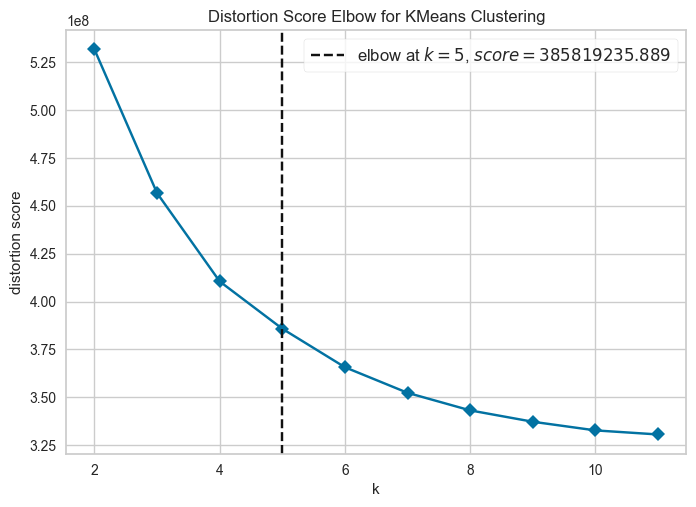

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# Initialize KClusterer
KClusterer = KMeans(n_clusters=3,
                    verbose=0,
                    random_state=2025)
# Use KElbowVisualizer to find optimal number of clusters
visualizer = KElbowVisualizer(KClusterer, # Cluster model with any parameters you need
                              k=(2,12),   # Number of clusters to test (2 to 12 in this case)
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=False # Plot the timings to train?
                             )

visualizer.fit(scaled_df)       # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<p>The elbow method gives us n=5 clusters.</p> 
<p>Now, let's use the silhouette method to identify the optimal number of clusters.</p>

In [11]:
# Number of clusters
n_clusters = 5

# Fit the KMeans clusterer
kmeans = KMeans(n_clusters=n_clusters, random_state=2025)
kmeans_labels = kmeans.fit_predict(scaled_df)

# Compute silhouette scores per sample
sample_silhouette_values = silhouette_samples(scaled_df, kmeans_labels)
kmeans_sil_avg = silhouette_score(scaled_df, kmeans_labels)

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Set axis limits
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(scaled_df) + (n_clusters + 1) * 10])

y_lower = 10

# Plot silhouette bars cluster by cluster
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_values,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

# Draw average line
ax.axvline(x=kmeans_sil_avg, color="red", linestyle="--")

# Labels
ax.set_title("Silhouette Plot for KMeans (k=5)")
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster label")
ax.set_yticks([])

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Now we will apply a linear dimensionality reductions technique to the data.
1. Apply PCA to your data.
2. Plot the data of the first two PCs in a scatterplot and colour the points as
per the cluster labels you calculated in the previous step. What can you say
about your data? Are your clusters clearly defined in the output? Interpret
the first three components of your PCA output.
3. For the first three components, calculate the average value of each
component, for each cluster, so your data should look like a table with
cluster number and average component value. Give a name to the clusters
from this output and justify your choice.

 Now, use UMAP to reduce the data to two dimensions. Justify your choice of
parameters by searching for the optimal value as you deem reasonable. Again,
colour the data to differentiate each cluster that you named. What do you see? Is
your UMAP a better or worse interpretation than PCA?

<h1>Part 2: Regression</h1>

Now we will create models for a household’s proportion of income spent
on total personal insurance premiums and retirement/pension contributions.

Train a regularized elastic net linear regression from your data.

1. Create your target variable from the variables in the dataset. Do not use
those components on the training database.
2. Apply any data transformation / variable creation you deem necessary to
obtain a good result.
3. Discuss the grid that you chose to search for the parameters and the output
that you obtained.
4. For your test set, create a scatterplot of the original response and the
predicted response. Report the MSE and R2 on the test set and calculate a
bootstrapped confidence interval of the output.
5. Interpret the coefficients of the top five most important variables in the
regression